# Customer Segmentaion - Online Retail dataset
This project aims to segment customers of a real online retail transaction dataset.
The dataset can be found in the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Online+Retail+II#.

Some information about the dataset from the repository:
The dataset contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011 (2 years). The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

Attribute Information:

* InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
* StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
* Description: Product (item) name. Nominal.
* Quantity: The quantities of each product (item) per transaction. Numeric.
* InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.
* UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).
* CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
* Country: Country name. Nominal. The name of the country where a customer resides.

At first, we will explore the dataset, clean, and preprocess. Then, we will produce the RFM analysis. Later, we will apply clustering algorithms for the segmentation process, and compare between the different algorithms. Base on the comaprison we will choose the optimal algorithm for our data and produce information and insights about each segment comes out the algorithm.
At each stage, we will explain it's motivation at the beginning.

## Importing libraries

In [114]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import datetime
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

## Reading the data (two spreadsheets)

In [115]:
data = pd.read_excel('online_retail_II.xlsx',sheet_name = ['Year 2009-2010', 'Year 2010-2011'])

In [116]:
df = data['Year 2009-2010'].append(data['Year 2010-2011']).reset_index(drop=True)

## Exploring and preprocessing
This step is designed to find significant insights in the dataset. We will examine the features in the dataset, remove unnecessary records, and so on.

In [117]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


**1,067,371 total records in the dataset.
We can see that there are missing values in both the Description column and the Customer ID column that we will address below.**

### Uniqueness information:

In [119]:
basic_df = pd.DataFrame(columns=['feature','uniqueness_count'])

dic = {'feature': 'Invoices', 'uniqueness_count': len(df.Invoice.unique())}
basic_df = basic_df.append(dic, ignore_index = True)

dic = {'feature': 'Customers', 'uniqueness_count': len(df['Customer ID'].unique())}
basic_df = basic_df.append(dic, ignore_index = True)

dic = {'feature': 'Country', 'uniqueness_count': len(df.Country.unique())}
basic_df = basic_df.append(dic, ignore_index = True)

dic = {'feature': 'Description', 'uniqueness_count': len(df.Description.unique())}
basic_df = basic_df.append(dic, ignore_index = True)  

basic_df

,feature,uniqueness_count
0,Invoices,53628
1,Customers,5943
2,Country,43
3,Description,5699


**From this dataframe we created, we can see the number of distinct values for each feature.
There are 53,628 unique orders, 5,943 different customers, 43 countries from which the orders were ordered, and 5,699 different products in the dataset.**

### Stripping the datetime from the InvoiceDate column to Y-m-d format:
this process will be helpful later for the RFM analysis.

In [120]:
df['InvoiceDate'] = df['InvoiceDate'].apply(lambda x: datetime.datetime.strptime(str(x).split()[0], '%Y-%m-%d'))

In [121]:
df['InvoiceDate']

0         2009-12-01
1         2009-12-01
2         2009-12-01
3         2009-12-01
4         2009-12-01
             ...    
1067366   2011-12-09
1067367   2011-12-09
1067368   2011-12-09
1067369   2011-12-09
1067370   2011-12-09
Name: InvoiceDate, Length: 1067371, dtype: datetime64[ns]

### Removing records that do not contain a Customer ID:

In [122]:
missing_values_count = df['Customer ID'].isnull().sum()
missing_values_percentage = int(round(missing_values_count / df.shape[0], 2) * 100)
missing_values_percentage
print(f'There are {missing_values_count:,} out of {df.shape[0]:,} records with missing value in the Customer ID column.')
print(f'({missing_values_percentage}%)')

There are 243,007 out of 1,067,371 records with missing value in the Customer ID column.
(23%)


In [123]:
df = df.dropna(subset=['Customer ID'])

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824364 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      824364 non-null  object        
 1   StockCode    824364 non-null  object        
 2   Description  824364 non-null  object        
 3   Quantity     824364 non-null  int64         
 4   InvoiceDate  824364 non-null  datetime64[ns]
 5   Price        824364 non-null  float64       
 6   Customer ID  824364 non-null  float64       
 7   Country      824364 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 56.6+ MB


**We can see that after removing the relevant records, we have no more columns with empty entries in the dataset.**

### Removing duplicated records:

In [125]:
dup_records = df.duplicated().sum()
dup_percentage = round((dup_records / df.shape[0])*100, 2)
print(f"Number of duplicated records in the dataset: {dup_records:,} ({dup_percentage}% out of total)")

Number of duplicated records in the dataset: 26,481 (3.21% out of total)


In [126]:
df = df.drop_duplicates()

### Exploring the canceled invoices:

In [127]:
# Creating a column contain True if an invoice is canceled (InvoiceNo starts with "C")
df['Canceled'] = df['Invoice'].apply(lambda x: False if not str(x).startswith('C') else True)

In [128]:
can_orders = df['Canceled'].sum()
can_percentage = round((can_orders / df.shape[0])*100, 2)
print(f"Number of canceled orders in the dataset: {can_orders:,} ({can_percentage}% out of total)")

Number of canceled orders in the dataset: 18,390 (2.3% out of total)


In [129]:
# Grouping by Customers
# looking at the total count and canceled orders, and the percentage of those canceled orders out of the total
grouped_customers = df.groupby('Customer ID')
grouped_customers
customers_df = pd.DataFrame(grouped_customers.count().iloc[:,-1]).rename(columns={'Canceled': 'total_count'})
customers_df['canceled'] = grouped_customers['Canceled'].sum()
customers_df['percentage_of_cancellations'] = round((customers_df.canceled / customers_df.total_count), 2)
print(f"There are {(customers_df['percentage_of_cancellations'] == 1).sum()} customers whose all of their orders have been canceled.")
customers_df

There are 61 customers whose all of their orders have been canceled.


,total_count,canceled,percentage_of_cancellations
Customer ID,,,
12346.0,47,13,0.28
12347.0,222,0,0.00
12348.0,51,0,0.00
12349.0,180,5,0.03
12350.0,17,0,0.00
...,...,...,...
18283.0,938,0,0.00
18284.0,29,1,0.03
18285.0,12,0,0.00


In [130]:
temp_df = customers_df[customers_df['percentage_of_cancellations'] != 1] # Removing those 100% cacellation customers
temp_df = temp_df.sort_values(['total_count', 'percentage_of_cancellations'], ascending=False)
temp_df.head(20) # Display top 20 (total count and percentage of canceled orders)

,total_count,canceled,percentage_of_cancellations
Customer ID,,,
17841.0,12638,203,0.02
14911.0,11444,365,0.03
12748.0,6662,75,0.01
14606.0,6500,141,0.02
14096.0,5128,17,0.00
15311.0,4579,273,0.06
14156.0,4118,80,0.02
14646.0,3890,36,0.01
13089.0,3391,75,0.02


In [131]:
temp_df.head(200).mean()

total_count                    1253.1000
canceled                         26.8300
percentage_of_cancellations       0.0211
dtype: float64

**Here we displayed the top 20 customers who has the most total count of orders. From this table above and the mean-summary, we can see that the cancellation percentage of the most valueable customers is very low (mean of 2.1% out of 1253 orders for the top 200 orders).Therefore, we can conclude that there are no meaninful patterns in the canceled orders for the customers in the data.**

In [132]:
# Grouping by Countries
# looking at the total count and canceled orders, and the percentage of those canceled orders out of the total
grouped_countries = df.groupby('Country')
grouped_countries
countries_df = pd.DataFrame(grouped_countries.count().iloc[:,-1]).rename(columns={'Canceled': 'total_count'})
countries_df['canceled'] = grouped_countries['Canceled'].sum()
countries_df['percentage_of_cancellations'] = round((countries_df.canceled / countries_df.total_count), 2)
countries_df.head()

,total_count,canceled,percentage_of_cancellations
Country,,,
Australia,1890,98,0.05
Austria,938,16,0.02
Bahrain,59,0,0.00
Belgium,3110,54,0.02
Brazil,94,0,0.00


In [133]:
temp_df = countries_df.copy()
temp_df = temp_df.sort_values(['total_count', 'percentage_of_cancellations'], ascending=False)
temp_df.head(20) # Display top 20 (total count and percentage of canceled orders, sorted by total_count and then by percentage)

,total_count,canceled,percentage_of_cancellations
Country,,,
United Kingdom,716113,15681,0.02
Germany,17339,899,0.05
EIRE,16014,447,0.03
France,13897,385,0.03
Netherlands,5137,47,0.01
Spain,3754,91,0.02
Belgium,3110,54,0.02
Switzerland,3058,52,0.02
Portugal,2414,58,0.02


In [134]:
temp_df = temp_df.sort_values(['percentage_of_cancellations', 'total_count'], ascending=False)
temp_df.head(20) # Display top 20 (total count and percentage of canceled orders, sorted by percentage and then by total_count)

,total_count,canceled,percentage_of_cancellations
Country,,,
USA,535,126,0.24
Japan,565,97,0.17
Czech Republic,30,5,0.17
Korea,63,10,0.16
Saudi Arabia,10,1,0.10
Channel Islands,1646,95,0.06
Malta,299,17,0.06
Germany,17339,899,0.05
Australia,1890,98,0.05


In [135]:
temp_df.head(200).mean()

total_count                    19460.560976
canceled                         448.536585
percentage_of_cancellations        0.036585
dtype: float64

**Here we displayed the top 20 countries which has the most total count of orders. From this table above and the mean-summary, we can see that the cancellation percentage of the most valueable countries is low, like for the customers before (mean of 3.6% for the top 200 orders).
An insghit here is that for United Kingdom, which produce most of the orders in the data (716,113 records), the canceled percentage is very low aswell (2%).**

Furthermore, we can observe from Table 2 that there are a few countries with a high percentage of cancelations - USA(24%), Japan(17%), Czech Republic(17%), Korea(16%), and Saudi Arabia(10%). This is a meaningful insight which worth further investigation within the company.

For our mission of segmentation, we will remove these canceled records from our dataset.

In [136]:
# Removing the canceled records from the dataset, and the Canceled column we added earlier
df = df[~df['Canceled']].drop(columns=['Canceled'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 779493 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      779493 non-null  object        
 1   StockCode    779493 non-null  object        
 2   Description  779493 non-null  object        
 3   Quantity     779493 non-null  int64         
 4   InvoiceDate  779493 non-null  datetime64[ns]
 5   Price        779493 non-null  float64       
 6   Customer ID  779493 non-null  float64       
 7   Country      779493 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 53.5+ MB


**The Quantity column contained negative values  according to the canceled records. This is a Check to see if there are still records with negative 'Quantity' values (supposed to be removed):**

In [137]:
df[df['Quantity']<=0].count()[0] # Check

0

### Looking at the distribution of the countries in that data:

In [138]:
# Percentage of records for each country (five most common countries)
countries_key = df.Country.value_counts(normalize = True).index.tolist()[:5]
countries_val = df.Country.value_counts(normalize = True).tolist()[:5]

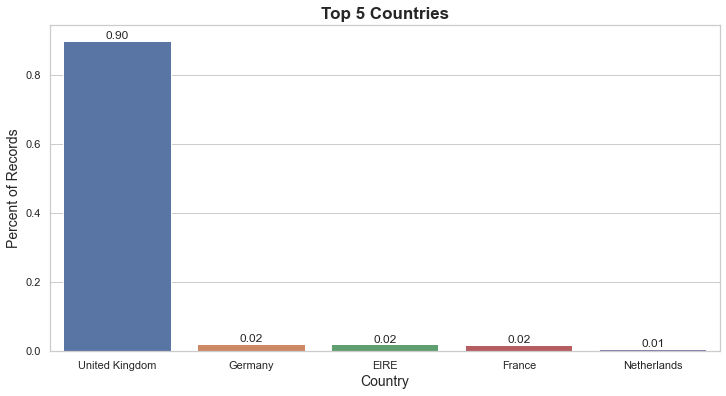

In [139]:
plt.figure(figsize=(12,6))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=countries_key, y=countries_val)
plt.title("Top 5 Countries", size=17, fontweight='bold')
plt.xlabel("Country", size=14)
plt.ylabel("Percent of Records", size=14)
for i in ax.containers:
    ax.bar_label(i,fmt='%.2f')
plt.show()

**UK's customers produced 90% of the data. The data is based on transactions for a UK-based and registered non-store online retail as mentioned at the beggining. For our purpose, we will remove records that did not ordered by customers from United Kingdom.**

In [140]:
df = df[df['Country'] == 'United Kingdom']

In [141]:
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700432 entries, 0 to 700431
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      700432 non-null  object        
 1   StockCode    700432 non-null  object        
 2   Description  700432 non-null  object        
 3   Quantity     700432 non-null  int64         
 4   InvoiceDate  700432 non-null  datetime64[ns]
 5   Price        700432 non-null  float64       
 6   Customer ID  700432 non-null  float64       
 7   Country      700432 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 42.8+ MB


In [142]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.0,United Kingdom


### Outliers detection:
in this section we will try to detect the outliers in the Price and Quantity columns if exists, and decide wether to remove them or not. 
Clustering algorithms, in particular K-Means, are very sensitive to outliers in the data, so it is recommended to treat them before applying the clustering process.

In [143]:
df[['Quantity','Price']].describe(percentiles=[0.01,0.02,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.98,0.99])

,Quantity,Price
count,700432.000000,700432.000000
mean,12.200917,3.065261
std,143.888220,25.597692
min,1.000000,0.000000
1%,1.000000,0.290000
2%,1.000000,0.360000
5%,1.000000,0.420000
10%,1.000000,0.550000
25%,2.000000,1.250000
50%,4.000000,1.950000


Using the describe method, we can see the statistics values of the specific columns. 
* **Quantity:** the mean value is 12.2 and the max value is 80,955 which is much larger than the mean.
* **Price:** the mean value is 3.065 and the max value is 10,953.5 which is much larger than the mean.

Looking at the percentiles, we can see that for the Price column, the 99% percentile is still at lower value, with small jumps between the percentiles. For the Quantity column, we can see a greater jumps, but still a big difference between the 99% percentile and the maximum value.

We will define the boundaries for keeping records that are lower than them. for the Quantity column, the boundary will be the 98% percentile (with the value of 72), and for the Price column, the boundary will be the 99% percentile (with the value of 12.75).

In [144]:
quantity_outliers = (df['Quantity'] > 108).sum()
price_outliers = (df['Price'] > 12.75).sum()
total_outliers = df.shape[0] - ((df['Quantity'] <= 108) & (df['Price'] <= 12.75)).sum()
print(f"""The amount of outliers in the Quantity column: {quantity_outliers:,}
The amount of outliers in the Price column: {price_outliers:,}

The total amount of outliers in our dataset based on the boundaries we set earlier is: {total_outliers:,}""")

The amount of outliers in the Quantity column: 6,921
The amount of outliers in the Price column: 6,192

The total amount of outliers in our dataset based on the boundaries we set earlier is: 13,109


In [145]:
# Removing the outliers from the dataset
df = df[(df['Quantity'] <= 108) & (df['Price'] <= 12.75)]
df.shape

(687323, 8)

**This is where the preprocessing process ends. Our dataset now contain 687,323 records.**

##  RFM Analysis

Recency, frequency, monetary value (RFM) is a marketing analysis tool used to identify a firm's best clients based on the nature of their spending habits.
An RFM analysis evaluates clients and customers by scoring them in three categories: how recently they've made a purchase, how often they buy, and the size of their purchases.RFM analysis helps firms reasonably predict which customers are likely to purchase their products again, how much revenue comes from new (versus repeat) clients, and how to turn occasional buyers into habitual ones.

### Recency
Recency: How recently a customer has made a purchase

In [146]:
df_copy = df.copy()
# Reference date (last purchase's date in the dataset[]\]';')
reference_date = df_copy.InvoiceDate.max() + datetime.timedelta(days = 1)
df_copy['days_from_last_purchase'] = (reference_date - df_copy.InvoiceDate).astype('timedelta64[D]')
# Calculating the number of days passed since the last purchase per customer
recency_df = df_copy[['Customer ID','days_from_last_purchase']].groupby('Customer ID').min().reset_index()
recency_df.rename(columns={'days_from_last_purchase':'Recency'}, inplace=True)
recency_df

,Customer ID,Recency
0,12346.0,530.0
1,12608.0,405.0
2,12745.0,487.0
3,12746.0,541.0
4,12747.0,3.0
...,...,...
5277,18283.0,4.0
5278,18284.0,432.0
5279,18285.0,661.0
5280,18286.0,477.0


In [147]:
df_copy.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,days_from_last_purchase
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom,739.0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,739.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,739.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085.0,United Kingdom,739.0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.0,United Kingdom,739.0


### Frequency
Frequency: How often a customer makes a purchase


In [148]:
# Calculating the number of orders purchased by each customer
frequency_df = df_copy[['Customer ID','Invoice']].groupby(['Customer ID','Invoice']).count().reset_index().\
groupby(["Customer ID"]).count().reset_index()
frequency_df.rename(columns = {'Invoice':'Frequency'}, inplace = True) 
frequency_df

,Customer ID,Frequency
0,12346.0,11
1,12608.0,1
2,12745.0,2
3,12746.0,1
4,12747.0,26
...,...,...
5277,18283.0,22
5278,18284.0,1
5279,18285.0,1
5280,18286.0,2


### Monetary
Monetary Value: How much money a customer spends on purchases

In [149]:
# Calculating the total amount of money spent per customer
df_copy['amount'] = df_copy.Quantity*df.Price
monetary_df = df_copy[['Customer ID','amount']].groupby('Customer ID').sum().reset_index()
monetary_df.rename(columns = {'amount':'Monetary'}, inplace = True) 
monetary_df

,Customer ID,Monetary
0,12346.0,372.86
1,12608.0,415.79
2,12745.0,723.85
3,12746.0,254.55
4,12747.0,8353.08
...,...,...
5277,18283.0,2648.95
5278,18284.0,411.68
5279,18285.0,347.10
5280,18286.0,1156.63


### RFM Table

In [150]:
# Merging the r,f,m dataframes into one
rfm_df = pd.merge(pd.merge(recency_df,frequency_df),monetary_df)

In [151]:
rfm_df

,Customer ID,Recency,Frequency,Monetary
0,12346.0,530.0,11,372.86
1,12608.0,405.0,1,415.79
2,12745.0,487.0,2,723.85
3,12746.0,541.0,1,254.55
4,12747.0,3.0,26,8353.08
...,...,...,...,...
5277,18283.0,4.0,22,2648.95
5278,18284.0,432.0,1,411.68
5279,18285.0,661.0,1,347.10
5280,18286.0,477.0,2,1156.63


## Clustering with K-means

 In this section we will use k-means clustering to cluster the customers in the dataset.
 There are two assumptions, that the k-means works better with it:
 * There is no skeweness in the data
 * The data is on the same scale (standartization)
 
 we will try to accomplish these assumptions first and then cluster the customers to different segments, based on the RFM table.

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

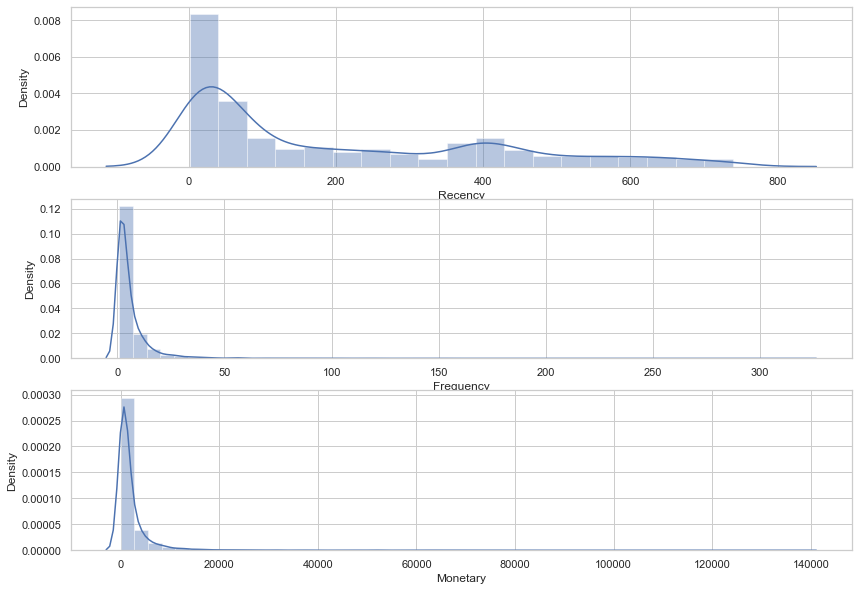

In [152]:
# Checking the distribution of Recency, Frequency and Monetary Values
plt.figure(figsize=(14,10))

plt.subplot(3, 1, 1); sns.distplot(rfm_df['Recency'])
plt.subplot(3, 1, 2); sns.distplot(rfm_df['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(rfm_df['Monetary'])

### We are using the log-transformation to reduce the skeweness. Then we are standardizing the log-features:

In [153]:
# Removing the skewness
df_rfm_log = rfm_df.copy()
df_rfm_log[['Recency', 'Frequency', 'Monetary']] = np.log(df_rfm_log[['Recency', 'Frequency', 'Monetary']]+1)

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

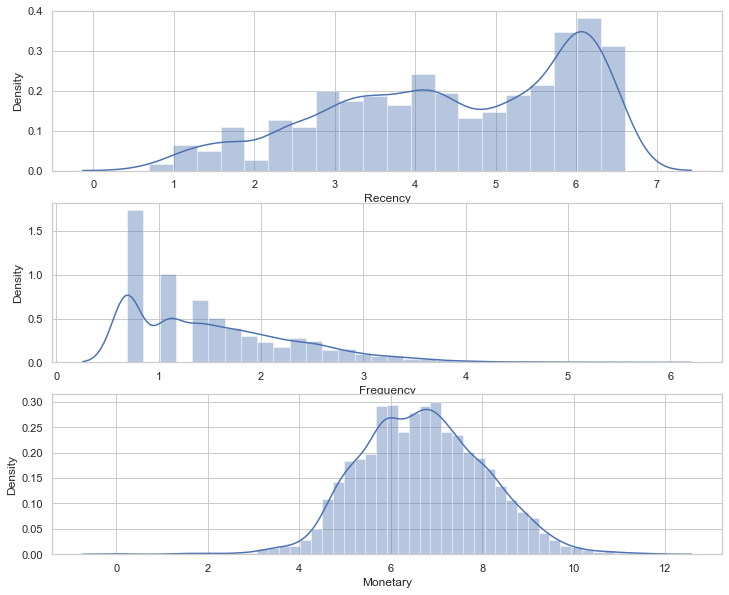

In [154]:
plt.figure(figsize=(12,10))

plt.subplot(3, 1, 1); sns.distplot(df_rfm_log['Recency'])
plt.subplot(3, 1, 2); sns.distplot(df_rfm_log['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(df_rfm_log['Monetary'])

The graphs above show the data distribution after the log transformation. You can see that the data is a little closer to normal. Although it is not a perfect solution, it gives relatively good results so we will continue with it.

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

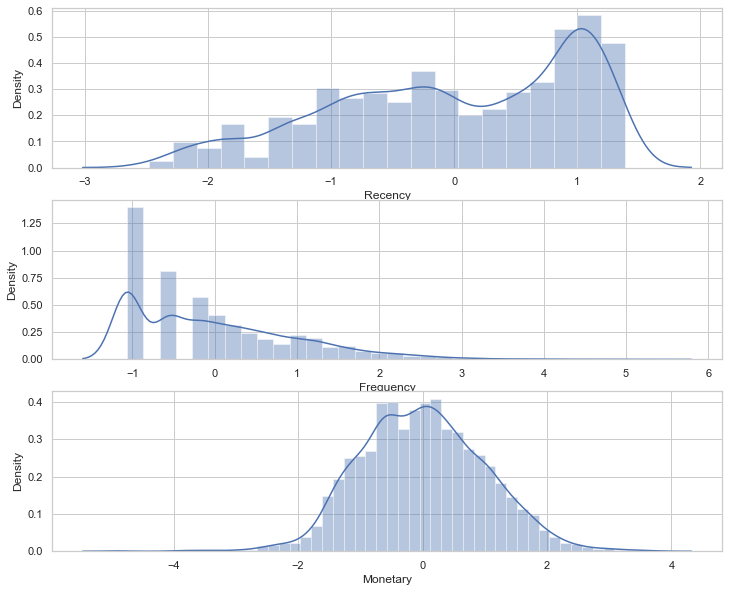

In [155]:
# Standardize the log-features
scaler = StandardScaler()
scaler.fit(df_rfm_log[['Recency', 'Frequency', 'Monetary']])
df_rfm_log_scaled = pd.DataFrame(scaler.transform(df_rfm_log[['Recency', 'Frequency', 'Monetary']]), columns=['Recency', 'Frequency', 'Monetary'])

plt.figure(figsize=(12,10))

plt.subplot(3, 1, 1); sns.distplot(df_rfm_log_scaled['Recency'])
plt.subplot(3, 1, 2); sns.distplot(df_rfm_log_scaled['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(df_rfm_log_scaled['Monetary'])

As you can see, the data on the scale is now similar and lower than before.
Now we can continue to the k-means.

### Using the Elbow Method to identify the optimal k-value for the K-Means:

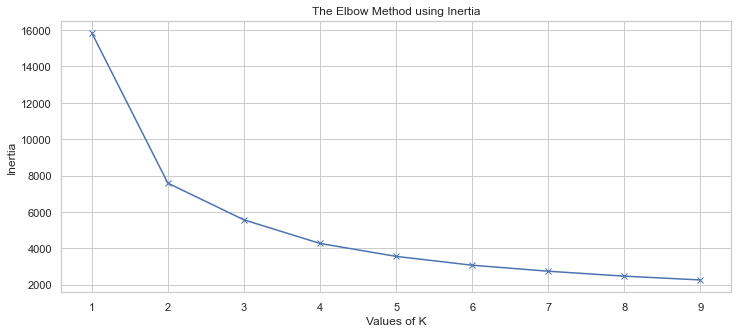

In [156]:
rfm_table_final = df_rfm_log_scaled[['Recency', 'Frequency', 'Monetary']]

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(rfm_table_final) 
    kmeanModel.fit(rfm_table_final)     
      
    distortions.append(sum(np.min(cdist(rfm_table_final, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / rfm_table_final.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(rfm_table_final, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / rfm_table_final.shape[0] 
    mapping2[k] = kmeanModel.inertia_

plt.figure(figsize=(12,5))
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

From this graph we can assume that the optimal k value is 3. We will try to cluster for 2,3,4 clusters and see what we've got.

### Applying the k-means:

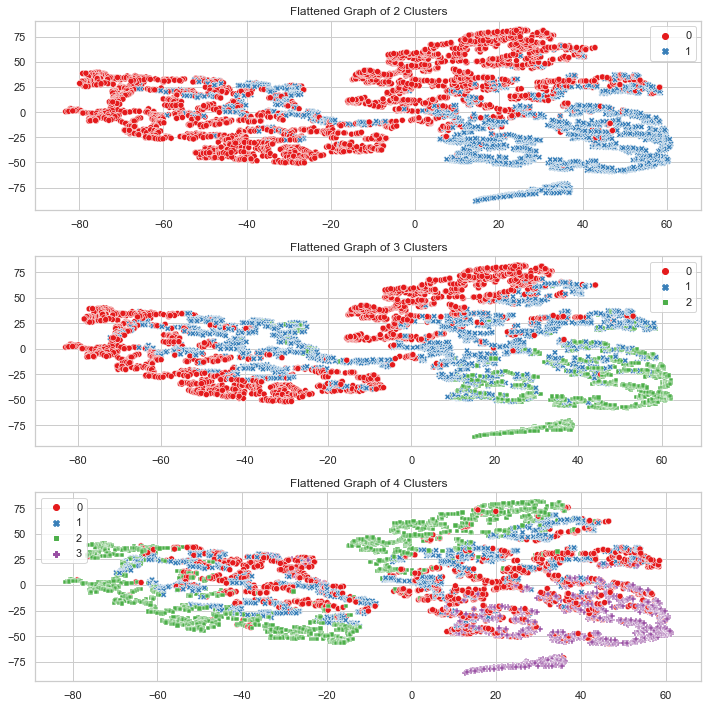

In [157]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)
    
    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k2 = kmeans(rfm_table_final, 2, rfm_df)

plt.subplot(3, 1, 2)
df_rfm_k3 = kmeans(rfm_table_final, 3, rfm_df)

plt.subplot(3, 1, 3)
df_rfm_k4 = kmeans(rfm_table_final, 4, rfm_df)

plt.tight_layout()

From these flattened graphs we can see the the optimal k value is probably 2 clusters. Nevertheless, **we will choose to continue with 3 clusters** so that we can better represent the customers and segment them.

### Summarizing K-Means clustering:

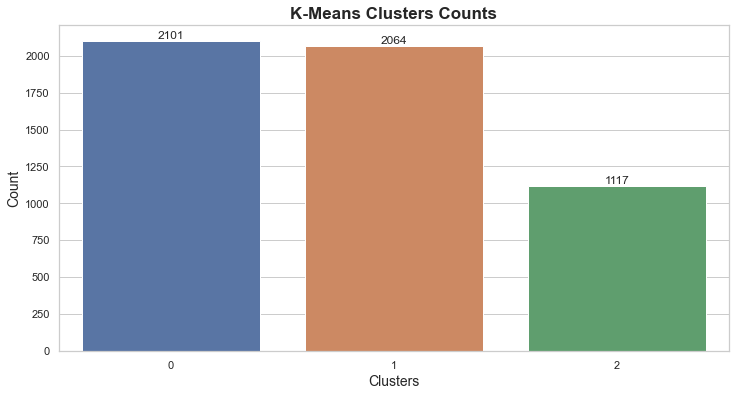

In [158]:
df_clusters_dist = df_rfm_k3.groupby(['Cluster']).count().iloc[:,1:2]
df_clusters_dist.rename(columns={'Recency':'Count'}, inplace=True)

clusters_key = df_clusters_dist.index.tolist()
clusters_val = df_clusters_dist['Count'].tolist()

plt.figure(figsize=(12,6))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=clusters_key, y=clusters_val)
plt.title("K-Means Clusters Counts", size=17, fontweight='bold')
plt.xlabel("Clusters", size=14)
plt.ylabel("Count", size=14)
for i in ax.containers:
    ax.bar_label(i,fmt='%d')
plt.show()

From the graph above we can see the ditribution of the customers in the different clusters. The data distribution is uniform between clusters 1 and 2, with respect to cluster 3: there are fewer observations in it.

In [159]:
final_df = df_rfm_k3.groupby(['Cluster']).agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': 'mean'}).round(0)
final_df

,Recency,Frequency,Monetary
Cluster,,,
0,382.0,2.0,339.0
1,114.0,4.0,1248.0
2,34.0,18.0,7197.0


This table displaying the **mean** value of the recency, frequency and monetary for each cluster.

**Description and conclusions about the clusters:**

* **Cluster 0**: The company's "worst" customer. Makes only two purchases in a low-average amount, with a last purchase of a year ago or more.


* **Cluster 1**: The average customer - a fairly long last purchase with 4 purchases in total over the two years and a mediocre amount of money spent.


* **Cluster 2**: These are the "Whales" of the company - an highly average amount of money spent, high number of purchases during the two years period and a relatively recent last purchase (34 days) in average. 

Through this insights and segmentation, the company can decide on promotion and advertising for each such cluster individually, with an over-focus on customers in terms of recency, frequency and monetary values.

In [160]:
# Silhouette Score
range_n_clusters = range(2, 5)

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state = 1)
    preds = clusterer.fit_predict(rfm_table_final)
    score = silhouette_score(rfm_df, preds)
    print("For n_clusters = {}, silhouette score is {:.2}".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.26
For n_clusters = 3, silhouette score is 0.024
For n_clusters = 4, silhouette score is -0.029


We can see that the Silhouette Score is larger for 2 clusters. This is a decision for the company to make: should be based on a better score or a lower score but the ability to segment "better" the company's customers.

## Clustering with DBSCAN

At first we need to estimate the DBSCAN’s two parameters:
* Minimum samples ("MinPts"): the fewest number of points required to form a cluster
* ε ("eps"): the maximum distance two points can be from one another while still belonging to the same cluster

for **MinPts**, there is a rule of thumb that says: if your data has more than 2 dimensions, choose MinPts = 2 x dim, where dim is the dimensions of your data set.
for **eps (epsilon)**, we will use an automatic technique that calculates the average distance between each point and its k nearest neighbors, where k = the MinPts value we selected. The average k-distances are then plotted in ascending order on a k-distance graph. The optimal value for ε will be found at the point of maximum curvature.

Our dataset contain 3 dimensions (R F M). thus, we will select the MinPts to be 2 x 3 dim = 6.
After selecting this, we will move on to calculate the epsilon.

In [161]:
DBSCAN_df_rfm = rfm_df.copy()

In [162]:
DBSCAN_df_rfm

,Customer ID,Recency,Frequency,Monetary
0,12346.0,530.0,11,372.86
1,12608.0,405.0,1,415.79
2,12745.0,487.0,2,723.85
3,12746.0,541.0,1,254.55
4,12747.0,3.0,26,8353.08
...,...,...,...,...
5277,18283.0,4.0,22,2648.95
5278,18284.0,432.0,1,411.68
5279,18285.0,661.0,1,347.10
5280,18286.0,477.0,2,1156.63


In [163]:
# Standardize
scaler = StandardScaler()
scaler.fit(DBSCAN_df_rfm[['Recency', 'Frequency', 'Monetary']])
DBSCAN_df_rfm_scaled = pd.DataFrame(scaler.transform(DBSCAN_df_rfm[['Recency', 'Frequency', 'Monetary']]), columns=['Recency', 'Frequency', 'Monetary'])

In [164]:
DBSCAN_df_rfm_scaled

,Recency,Frequency,Monetary
0,1.554156,0.423853,-0.322878
1,0.959275,-0.449992,-0.315054
2,1.349517,-0.362607,-0.258914
3,1.606506,-0.449992,-0.344438
4,-0.953862,1.734619,1.131426
...,...,...,...
5277,-0.949103,1.385081,0.091914
5278,1.087770,-0.449992,-0.315803
5279,2.177592,-0.449992,-0.327572
5280,1.301927,-0.362607,-0.180044


### Using k-nearest neighbors to determine the epsilon value:

In [165]:
neighbors = NearestNeighbors(n_neighbors=6)
neighbors_fit = neighbors.fit(DBSCAN_df_rfm_scaled[['Recency', 'Frequency', 'Monetary']])
distances, indices = neighbors_fit.kneighbors(DBSCAN_df_rfm_scaled[['Recency', 'Frequency', 'Monetary']])

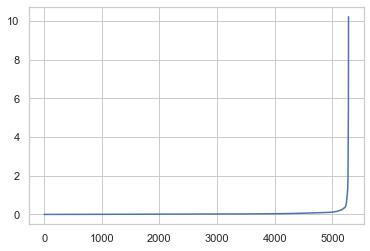

In [166]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

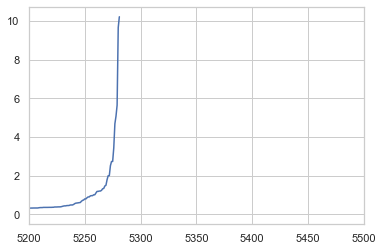

In [167]:
# Zooming in to find the optimal value
plt.xlim(5200,5500)
plt.plot(distances)

It looks like the optimal value for ε is around 3.0 . We will try out 2.0, 3.0 and 4.0, since it's not that clearly.

### Applying the DBSCAN:

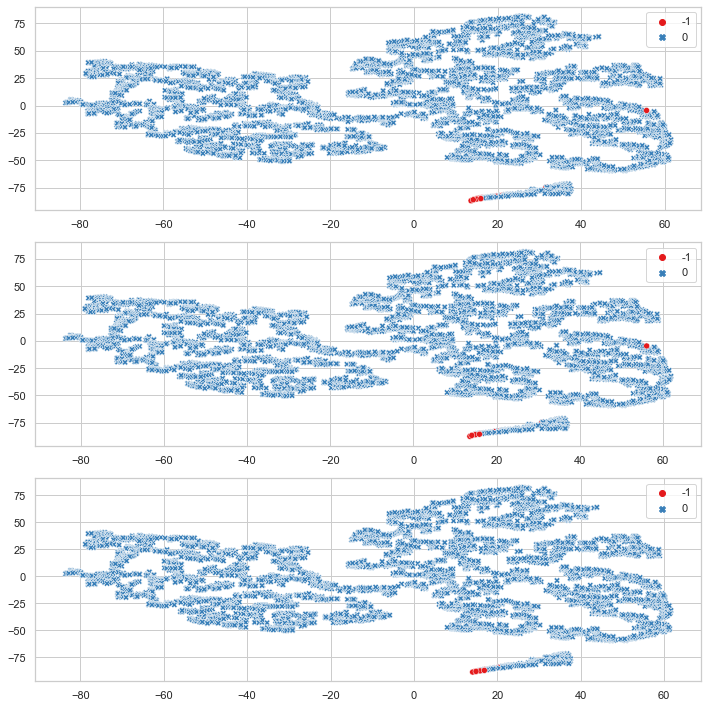

In [168]:
def dbscan(normalised_df_rfm, original_df_rfm, eps, min_samples=6):
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    
    # Extract cluster labels
    cluster_labels = dbscan.fit_predict(normalised_df_rfm)
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new


rfm_table_final_dbscan = DBSCAN_df_rfm_scaled[['Recency', 'Frequency', 'Monetary']]

plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_dbscan_1 = dbscan(rfm_table_final_dbscan, DBSCAN_df_rfm, 2.0)

plt.subplot(3, 1, 2)
df_rfm_dbscan_2 = dbscan(rfm_table_final_dbscan, DBSCAN_df_rfm, 3.0)

plt.subplot(3, 1, 3)
df_rfm_dbscan_3 = dbscan(rfm_table_final_dbscan, DBSCAN_df_rfm, 4.0)

plt.tight_layout()

In [169]:
# Silhouette Score

score1 = silhouette_score(df_rfm_dbscan_1, df_rfm_dbscan_1['Cluster'])
print(f"For ε = {2.0}, silhouette score is {score1:.2}")

score2 = silhouette_score(df_rfm_dbscan_2, df_rfm_dbscan_2['Cluster'])
print(f"For ε = {3.0}, silhouette score is {score2:.2}")

score3 = silhouette_score(df_rfm_dbscan_3, df_rfm_dbscan_3['Cluster'])
print(f"For ε = {4.0}, silhouette score is {score3:.2}")

For ε = 2.0, silhouette score is 0.93
For ε = 3.0, silhouette score is 0.94
For ε = 4.0, silhouette score is 0.95


We can see in the graphs above that there are clusters with a very small number of samples, based on the min_samples=6 as we have defined (according to the rule of thumb).
It can be said quite clearly that **this is not a performance that will benefit the company.** Although the Silhouette coefficient indicates that the algorithm works great, it can be seen that this is happening because the size of the clusters is very small, as said.
Therefore, we suggest not to rely on this algorithm, or try to make improvements like increasing the min_sample to higher values and/or playing with the epsilon values.

## Coclusion:


In this project we tried to segment customers of an online retail store. We explored and preprocess the data, and then applyed k-means and DBSCAN algorithms for that purpose of segmentation. 
In conclusion, it can be said that k means provided insights and segmentation, maybe not the best there is but still something to work with.
DBSCAN, on the other hand, did not provide interesting insights or anything to work with.
A recommendation for follow-up work is to try to make a broader game with the parameters of the DBSCAN, or alternatively to try various other clustering algorithms.